<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Keras_VAE_CNN_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of a Variational Autoencoder on Fashion MNIST Dataset

The VAE has a modular design. The encoder, decoder and VAE are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.  The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1. 

In VAE you assume that distribution over latent variables is multivariate normal with diagonal covariance matrix, and penalize using KL divergence from standard normal distribution. This KL divergence can be calculated using mean and covariance matrix of the distribution that is being sampled.

## Reference

[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Layer, Conv2DTranspose, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import tensorflow as tf


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and Fashion MNIST images as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    
    x_test, y_test = data
    encoder, decoder = models

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

image_size = x_train.shape[1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

def build_callbacks():
    modelCP = ModelCheckpoint(filepath='vae_mlp_mnist.h5', 
                                monitor='val_loss', 
                                verbose=0, 
                                save_best_only=True, 
                                period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', 
                    patience=7, 
                    verbose=1, 
                    factor=0.2, 
                    min_lr=0.00001)
    callbacks = [modelCP,  LR]
    return callbacks



4431872/4422102 [==============================] - 0s 0us/step


## Build Encoder

In [3]:
# network parameters

intermediate_dim = 512

# VAE model = encoder + decoder
# build encoder model
latent_dim = 2

encoder_inputs = Input(shape=(28, 28, 1))
cx = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
cx = BatchNormalization()(cx)
cx = Conv2D(64, 3, activation="relu", strides=2, padding="same")(cx)
cx = BatchNormalization()(cx)
x = Flatten()(cx)
x = Dense(64, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

conv_shape = K.int_shape(cx)
print((conv_shape[1], conv_shape[2], conv_shape[3]))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['batch_normalization[0][0]

# Build Decoder

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       1846

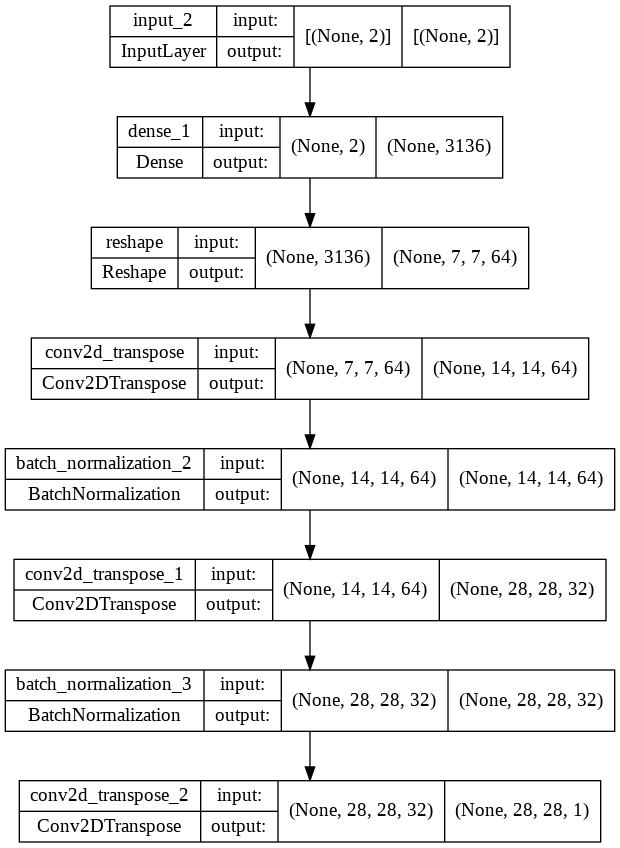

In [4]:

latent_inputs = Input(shape=(latent_dim,))
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu")(latent_inputs)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)




# Build VAE

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               220228    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65473     
                                                                 
Total params: 285,701
Trainable params: 285,317
Non-trainable params: 384
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
469/469 [==============================] - 20s 13ms/step - loss: 0.3707 - val_loss: 0.4319 - lr: 0.0010
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3355 - val_loss: 0.3335 - lr: 0.0010
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3312 - val_loss: 0.3306 - lr: 0.0010
Epoch 4/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3284 - val_loss: 0.3284 - lr: 0.0010
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3265 - val_loss: 0.3278 - lr: 0.0010
Epoch 6/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3249 - val_loss: 0.3256 - lr: 0.0010
Epoch 7/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3237 - val_loss: 0.3264 - lr: 0.0010
Epoch 8/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3227 - val_loss: 0.3246 - lr: 0.0010
Epoch 9/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3

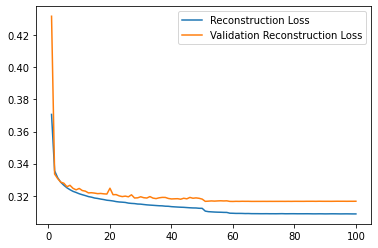

In [5]:
batch_size = 128
epochs = 100

if isinstance(encoder_inputs, tuple):
    encoder_inputs = encoder_inputs[0]
z_mean, z_log_var, z = encoder(encoder_inputs)
# instantiate VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae_mlp')
models = (encoder, decoder)
test_data = (x_test, y_test)

optim = optimizers.Nadam(lr=.001)
#optim = optimizers.SGD(lr=0.007, decay=.01, momentum=0.9, nesterov=True)

vae.compile(optimizer=optim,  loss = 'binary_crossentropy')
vae.summary()
plot_model(vae,
            to_file='vae_mlp.png',
            show_shapes=True)

hist = vae.fit(x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=build_callbacks(),
            validation_data=(x_test, x_test)
            )
epoch_list = list(range(1, len(hist.history['loss']) + 1))
plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Reconstruction Loss", "Validation Reconstruction Loss"))
plt.show()

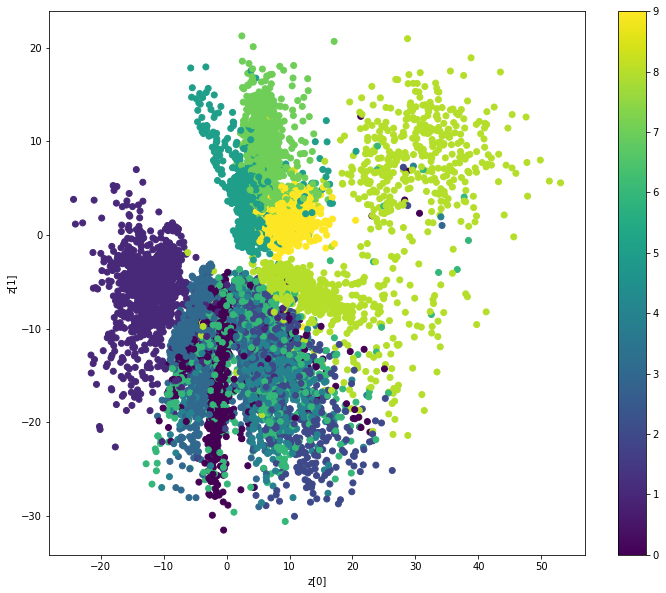

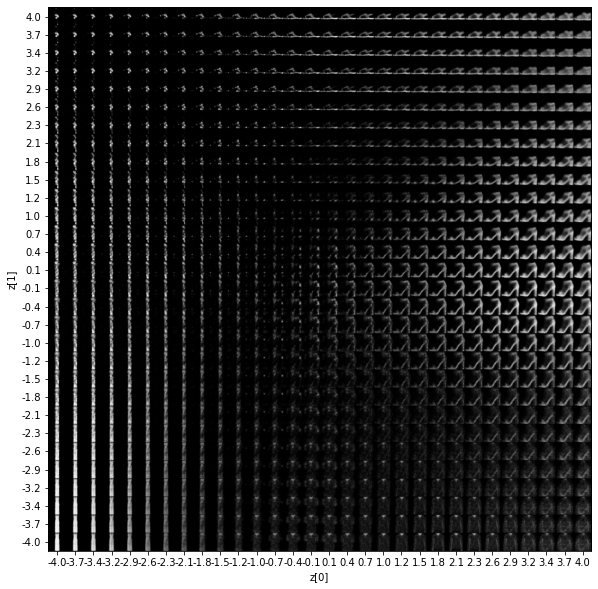

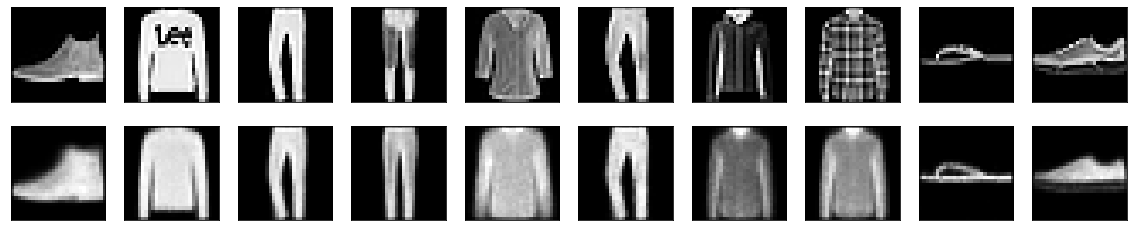

In [6]:
vae = load_model('vae_mlp_mnist.h5', custom_objects={'Sampling': Sampling})
encoder = vae.layers[-2]
decoder = vae.layers[-1]
data = (x_test, y_test)
models = (encoder, decoder)

plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

# Use trained VAE to infer images from test images
decoded_imgs = vae.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()